In [24]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [25]:
import numpy as np
import pandas as pd

In [26]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [28]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [29]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [30]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [31]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [32]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [33]:
#Finding out about the column names
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x122974d30>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [34]:
# Converting from DateTime type to a String
from dateutil.relativedelta import relativedelta

query_dates = session.query(Measurement.date).all()

dates = [date[0] for date in query_dates]
last_date = max(dates)
first_date = min(dates)

last_date = dt.datetime.strptime(last_date, "%Y-%m-%d").date()

one_year_prior = last_date + relativedelta(months=-12)

last_date = last_date.strftime('%Y-%m-%d')
one_year_prior = one_year_prior.strftime('%Y-%m-%d')

print(first_date)
print(last_date)
print(one_year_prior)

2010-01-01
2017-08-23
2016-08-23


In [35]:
# Perform a query to retrieve the data and precipitation scores
from sqlalchemy import and_

results = session.query(Measurement.date, Measurement.prcp).filter(and_(Measurement.date <= last_date, Measurement.date >= one_year_prior)).all()

In [36]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['Dates', 'Preciptations'])
df.set_index('Dates', inplace=True, )
df.head()

,Preciptations
Dates,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [37]:
# Sort the dataframe by date
new_df = df.sort_values(by=['Dates'])
new_df.head()

,Preciptations
Dates,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


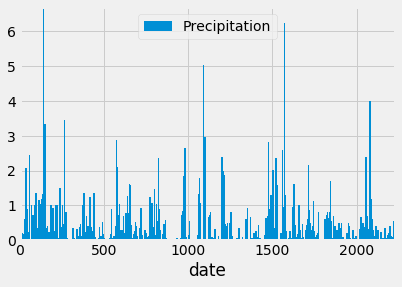

In [38]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = np.arange(len(new_df))
plt.bar(x_axis, new_df["Preciptations"], width=8)


plt.xlim(0, len(x_axis))
plt.ylim(0, max(new_df["Preciptations"]))
plt.xlabel("date")
plt.legend(["Precipitation"], loc='upper center')
plt.show()



![precipitation](Images/precipitation.png)

In [39]:
# Use Pandas to calcualte the summary statistics for the precipitation data

new_df.describe()

,Preciptations
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

### Station Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order.

  * Which station has the highest number of observations?

  * Hint: You may need to use functions such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries.

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.

    ![station-histogram](Images/station-histogram.png)

In [40]:
# Design a query to show how many stations are available in this dataset?

session.query(Measurement).distinct(Measurement.station).group_by(Measurement.station).count()


9

In [41]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

from sqlalchemy import desc

session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station =="USC00519281").all()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station =="USC00519281").all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station =="USC00519281").all()

print(f'The lowest temp in the station ID "USC00519281" is {[x[0] for x in lowest_temp]}.')
print(f'The highest temp in the station ID "USC00519281" is {[x[0] for x in highest_temp]}.')
print(f'The average temp in the station ID "USC00519281" is {[x[0] for x in avg_temp]}.')

The lowest temp in the station ID "USC00519281" is [54.0].
The highest temp in the station ID "USC00519281" is [85.0].
The average temp in the station ID "USC00519281" is [71.66378066378067].


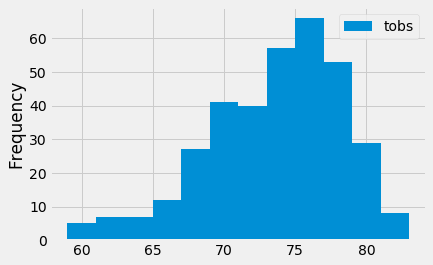

In [43]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_list = session.query(Measurement.tobs).filter(and_(Measurement.station =="USC00519281", Measurement.date <= last_date, Measurement.date >= one_year_prior)).all()

temp_list = [x[0] for x in temp_list]
plt.hist(temp_list, bins=12)
plt.ylabel("Frequency")
plt.legend(["tobs"], loc='upper right')

![precipitation](Images/station-histogram.png)